In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
class inv_Tracker():
    """Simula el detector Pixel del CMS en el HL-LHC.
    
        Args:
            
            r_max: distancia en la coordenada radial del último detector
            r_min: distancia en la coordenada radial del primer detector
            r_paso: distancia entre detectores
            h: longitud en el eje Z del Pixel
    """
    def __init__(self,r_min,r_max,h):
        self.r_min=r_min #2.5
        self.r_max=r_max #10
        r_paso=(self.r_max-self.r_min)/3
        self.h=h #60

    def detects(self, trayec, point, traza):
        """Proporciona los puntos de corte de la traza dada con el detector i.
            Cordenadas cilíndricas: (phi, z, detector)
            
            Args:
            
                trayec: Vector director de la traza(phi,z), se toma ese punto como si estuviera en el último
                anillo de detección: (phi, z, 4).
                point: Punto de partida de la traza en la dirección del beam (z), que en nuestro vector sería 
                (*,z,0)
                traza: numerador de traza, para posterior análisis
                
            Returns:
            
                coord: Matriz con los hits en cada detector. Se incluye error en phi y z.(phi,z,detector),
                el error muestra la incapacidad de calcular el punto exacto por el que pasa la traza, hay que añadir
                la distribución que tendría en la realidad.
        """
       
        coord = np.zeros( (4, 4) ) # (phi, z, detector, nº traza)
        for k in range(4):
            error=np.random.normal(0,0.01,2)
            
            coord[k][0]=trayec[0]+error[0]
            coord[k][1]=point+(trayec[1]-point)/self.r_max*(self.r_min+r_paso*k)
            coord[k][2]=k+1
            coord[k][3]=traza+1
            
        return coord

In [227]:
class Event():
    
    """ Simula un evento en el Pixel de manera aleatoria.
        
        Args:
            
            num: número de trazas forman el evento
            ruido: valor entre 0 y 1 que determine la cantidad de ruido
            
        
        
    """
    
    
    def __init__(self, num, ruido):
        
        self.num=num
        self.ruido=ruido
        global r_min
        global r_max
        global r_paso
        global h
        r_min=2.5
        r_max=100
        r_paso=(r_max-r_min)/3
        h=60.
        global point_rand
        global trayec_rand
        global pos_ruido
        global coord
        global theta
        global data
        theta=np.zeros((int(self.num*self.ruido)+self.num*4,1))
        point_rand = np.zeros( (self.num, 1) )
        trayec_rand = np.zeros( (self.num, 2) )  
        pos_ruido = np.zeros( (int(self.num*self.ruido),4) )
        coord=np.zeros( (self.num*4,4) )
        for k in range(self.num):

            point_rand[k]=0

            trayec_rand[k][0]=np.random.uniform(0,2*np.pi,1)
            trayec_rand[k][1]=np.random.normal(0,h/2,1)
            coord[int(4*k):int(4*k+4)]=inv_Tracker(r_min,r_max,h).detects(trayec_rand[k],point_rand[k],k)
            
        for i in range(int(self.num*self.ruido)):
            
            pos_ruido[i][0]=np.random.uniform(0,2*np.pi,1)
            pos_ruido[i][1]=np.random.normal(0,h/2*(1/4),1) 

            pos_ruido[i][2]=int(np.random.uniform(1,np.abs(pos_ruido[i][1]/3)+1))
       
    
        data=np.concatenate((coord,pos_ruido))
        
        for i in range(len(data)):
            theta[i]=np.arctan(data[i][1]/(r_min+(data[i][2]-1)*r_paso))
        data=np.append(data,theta,axis=1)
        
    def show_event(self,abrir,cerrar,azimut,cenital):
        
        """ Muestra en un plot un intervalo del evento, en radianes. El azimut y cenital se refieren a la posición del observador.

            Args:

                abrir: inicio del intervalo en phi a estudiar
                cerrar: final del intervalo en phi a estudiar
                azimut:
                cenital:

        """
        from mpl_toolkits.mplot3d import Axes3D
        import numpy as np

        import matplotlib.pyplot as plt

        fig1 = plt.figure(figsize = (20,20)) 
        env = fig1.add_subplot(111, projection='3d') 
        # Para que no pierda las proporciones
        env.scatter([-10,-10,10,10],[-10,10,-10,10],[-h/2,-h/2,-h/2,-h/2],color='b')
        env.scatter([-10,-10,10,10],[-10,10,-10,10],[h/2,h/2,h/2,h/2],color='b')

        # DETECTORES

        for i in range(5): # El primero es el beam

            no_values = 20
            phi_cyl = np.linspace(abrir, cerrar, no_values)
            x_walls = (r_min+(i-1)*r_paso)* np.cos(phi_cyl) 
            z_walls = np.linspace(-h/2, h/2, no_values)
            x2D_walls, z2D_walls = np.meshgrid(x_walls, z_walls)
            y2D_walls = np.sqrt((r_min+(i-1)*r_paso)**2 - x2D_walls**2)


            # Detector i
            env.plot_surface(x2D_walls, -y2D_walls, z2D_walls, color='y', alpha=0.1)
            env.plot_surface(x2D_walls, y2D_walls, z2D_walls, color='y', alpha=0.1)
            env.plot_wireframe(x2D_walls, y2D_walls, z2D_walls, rstride=1, cstride =1,color='k', alpha=0.05)
            env.plot_wireframe(x2D_walls, -y2D_walls, z2D_walls, rstride=1, cstride =1,color='k', alpha=0.05)

        # TRAZAS
      

        for k in range(self.num):
            
            x2=np.linspace(0,r_max*np.cos(coord[4*k][0]),30)
            y2=np.linspace(0,r_max*np.sin(coord[4*k][0]),30)
            z2=np.linspace(0,coord[4*k+3][1],30)

            env.plot(x2,y2,z2,color='m')
        # PUNTOS
        # 1) Hits
        for j in range(4*self.num):
            env.scatter((r_min+(coord[j][2]-1)*r_paso)*np.cos(coord[j][0]),(r_min+(coord[j][2]-1)*r_paso)*np.sin(coord[j][0]),coord[j][1],color='k')
        # 2) Ruido
        for k in range(int(self.num*self.ruido)):
            env.scatter((r_min+(pos_ruido[k][2]-1)*r_paso)*np.cos(pos_ruido[k][0]),(r_min+(pos_ruido[k][2]-1)*r_paso)*np.sin(pos_ruido[k][0]),pos_ruido[k][1],color='r')
        
        # REPRESENTACION

        
        env.view_init(180/np.pi*cenital, 180/np.pi*azimut)


        plt.show()

    def export_event(self):
         
        file=open('/home/pablo/Desktop/TFG/Qiskit/OutputEvent.txt', 'w')
        file.write(tabulate(data, headers=['Phi', 'z', 'Detector','Traza','Theta']))

        
        file.close()
        return file
    
    def export_edges(self):
        data_aux=np.array([[ 2.22138175,  2.98406198,  1.0],
           [ 3.95283383, 4.01434945,  1.0000000],
           [ 5.75131060, 6.27374530,  1.000000],
           [ 2.24772953,  5.96812397,  2.000000000],
           [ 3.93880056, 8.02869890,  2.000000000],
           [ 5.74861872, 12.5474906,  2.00000000],
           [ 5.75117227, 1.212359,  3.00000000],
           [ 2.34403100,  8.95218595,  3.00000],
           [ 3.93649848, 12.040483,  3.000000000],
           [ 5.75117227, 1.22359,  4.00000000],
           [ 2.34403100,  11.9218595,  4.00000],
           [ 3.93649848, 16.0430483,  4.000000000]])
        plt.scatter(data_aux[:,1],r_paso*data_aux[:,2])
        a=np.zeros((27,3))
        cont1=0
        cont2=0
        base=3
        for i in range(27):
            a[i][[0,1]]=[cont1,base+cont2]
            a[i][2]=-data_aux[cont1][1]+data_aux[base+cont2][1]
            cont2=cont2+1
            if (i+1)%3==0:
                cont1=cont1+1
                cont2=0
            if (i+1)%9==0:
                base=base+3
            
        return  a
    def export_cos_matrix(self,a):
        weights=np.zeros((27,27))
        a1a2=np.zeros((54,3))
        cont1=0
        cont2=9
        nivel=8
        for i in range(54):
            a1a2[i][[0,1]]=[cont1,cont2]
            if a[cont1][2]*a[cont2][2]>0:
                a1a2[i][2]=np.pi/2+np.arctan(abs(a[cont1][2])/r_paso)+np.arctan(r_paso/abs(a[cont2][2]))
            else:
                a1a2[i][2]=np.arctan(r_paso/abs(a[cont1][2]))+np.arctan(r_paso/abs(a[cont2][2]))
            weights[cont1][cont2]=round(-1/np.cos(a1a2[i][2]),10)
            weights[cont2][cont1]=round(-1/np.cos(a1a2[i][2]),10)
            if (i+1)%27==0:
                nivel=17
            if (i+1)%3==0:
                cont1=cont1+1
            if (cont2+1)%9==0:
                cont2=nivel

            cont2=cont2+1
        file=open('/home/pablo/Desktop/TFG/Qiskit/VQE_weights.txt', 'w')
        file.write(tabulate(np.round(weights,10), headers=['----------------', '----------------', '----------------','----------------','----------------','----------------','----------------', '----------------', '----------------','----------------','----------------','----------------','----------------', '----------------', '----------------','----------------','----------------','----------------']))

        
        file.close()
        return weights

[[ 0.00000000e+00  3.00000000e+00  2.98406199e+00]
 [ 0.00000000e+00  4.00000000e+00  5.04463692e+00]
 [ 0.00000000e+00  5.00000000e+00  9.56342862e+00]
 [ 1.00000000e+00  3.00000000e+00  1.95377452e+00]
 [ 1.00000000e+00  4.00000000e+00  4.01434945e+00]
 [ 1.00000000e+00  5.00000000e+00  8.53314115e+00]
 [ 2.00000000e+00  3.00000000e+00 -3.05621330e-01]
 [ 2.00000000e+00  4.00000000e+00  1.75495360e+00]
 [ 2.00000000e+00  5.00000000e+00  6.27374530e+00]
 [ 3.00000000e+00  6.00000000e+00 -4.75576497e+00]
 [ 3.00000000e+00  7.00000000e+00  2.98406198e+00]
 [ 3.00000000e+00  8.00000000e+00  6.07235903e+00]
 [ 4.00000000e+00  6.00000000e+00 -6.81633990e+00]
 [ 4.00000000e+00  7.00000000e+00  9.23487050e-01]
 [ 4.00000000e+00  8.00000000e+00  4.01178410e+00]
 [ 5.00000000e+00  6.00000000e+00 -1.13351316e+01]
 [ 5.00000000e+00  7.00000000e+00 -3.59530465e+00]
 [ 5.00000000e+00  8.00000000e+00 -5.07007600e-01]
 [ 6.00000000e+00  9.00000000e+00  1.12310000e-02]
 [ 6.00000000e+00  1.00000000e+

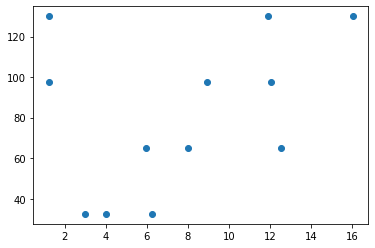

In [228]:
event=Event(60,2)
a=event.export_edges()
print(a)


In [219]:
event.export_cos_matrix(a)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.02872251,
        1.        , 1.00435434, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.06878689, 1.00793775, 1.00048606,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.23023536, 1.08404268, 1.04733021, 0.    

In [220]:
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit import IBMQ
import pickle
import sys
import matplotlib.pyplot as plt 
import networkx as nx

In [221]:
def variational_form(theta, n, depth): 
    """Forma variacional capaz de variar el autoestado de trabajo
        mediante rotaciones con puertas RY.
    
    En entrada:
        depth: número de capas de reajuste RY
        theta: (depth+1 x n) parámetros de rotación para cada qubit
            y para cada capa de reajuste RY,
        n: número de qubits,
        
    En salida::
        circuit: circuito cuántico para una iteración
    """
        
    if len(theta.ravel()) != ((depth+1) * n):        
        raise ValueError("La matriz de ánguos no puede escribirse como (depth+1 x n)")

    theta.shape = (depth + 1, n)

    # Inicialización
    q = QuantumRegister(n)
    c = ClassicalRegister(n)

    # Construcción del circuito 
    circuit = QuantumCircuit(q, c)

    # Rotación inicial de todos los qubits
    for i in range(n):
        circuit.ry(theta[0,i],q[i])
    circuit.barrier()
    
    # Reajustes en todos los qubits mediante matrices de control y rotación
    for j in range(depth):
        
        for i in range(n-1):
            circuit.cz(q[i], q[i+1])

       
        for i in range(n):
            circuit.ry(theta[j+1,i],q[i])
        circuit.barrier()
    
    # Medida final de los qubits
    circuit.measure(q, c)
    
    return circuit    

In [222]:
def cost_function(params,weights, n, depth, shots,cost,algorithm = 'VQE',alpha        = 0.5,verbosity    = False):
    """Crea el circuito cuántico con los parámetros dados, lo ejecuta shots veces y devuelve
        el coste de ese resultado.
    
    En entrada:
        params: matriz con los ángulos de reajuste,
        weights: matriz de los cosenos,
        n: número de qubits,
        depth: capas de reajuste del circuito cuántico,
        shots: evaluaciones del circuito cuántico,
        cost: función de coste que se va a utlizar. It can be: 
         - 'cost': mean value of all measured eigenvalues
         - 'cvar': conditional value at risk = mean of the
                   alpha*shots lowest eigenvalues,
        alpha: 'cvar' alpha parameter
        verbosity: información en la consola.
    
    En salida:
        output: coste de la configuración de autoestados hallado con COBYLA
    """
    
    if (verbosity == True):
        print("Arguments:")  
        print("params    = \n", params)
        print("weights   = \n", weights)
        print("qbits     = ", n)
        print("depth     = ", depth)
        print("shots     = ", shots)
        print("cost      = ", cost)
        print("algorithm = ", algorithm)
        print("alpha     = ", alpha)
    
    circuit = variational_form(params, n, depth)
    
    
    backend = Aer.get_backend('qasm_simulator')

    
    # Execute the circuit on a simulator
    job = execute(circuit, 
                  backend = backend, 
                  shots   = shots)
    results = job.result()
    
    # Autoestados de una etapa dada
    eigenstates = list(results.get_counts().keys())
    
    # Número de veces que aparece cada autoestados
    abundancies = list(results.get_counts().values())
    


    cost = 0
    
    for k in range(len(eigenstates)):
        # Vector númerico del autoestado k
        s = np.array([int(num) for num in eigenstates[k]]) #DEBE SER EL VECTOR DE ARISTAS DE 18 COMPONENTES
        # Coste total
        cost = cost + s.dot(weights.dot(s)) * abundancies[k] #NUESTRA MATRIZ NO ES SIMÉTRICA, PERO SÍ SE CUMPLE s(weights)s'función a minimizar  
   

    output = -cost / shots
 
    if (verbosity == True):
        print("cost = ", output)
        print(results.get_counts(circuit))

    return output



In [223]:
import time
from scipy.optimize import minimize


def VQE(shots,weights,n,depth,final_eval_shots, cost, alpha = 0.5,algorithm='VQE',theta = 1,verbosity = False):
    """ Resuelve el problema de optimización.
    .    
    
    En entrada:
    shots: evaluaciones del circuito cuántico,
    weights: matriz de los cosenos,
    n: número de qubits,
    depth:número de reajustes en el circuito cuántico,
    final_eval_shots: número de pasos para la ejecución del circuito final,
    cost: the cost function to be used. It can be: 
     - 'cost': mean value of all measured eigenvalues
     - 'cvar': conditional value at risk = mean of the
               alpha*shots lowest eigenvalues,
    alpha: 'cvar' alpha parameter
    algorithm: the optimization algorithm to be used (VQE or QAOA),
    theta: información sobre los angulos iniciales. Valor 1 si se utliza la rotacion RY
    verbosity: activate/desactivate some control printouts.
    
    En salida:
    elapsed_time: segundos que tarda en optimizar
    counts: dictionaty the results of the optimization
    shots: the 'shots' input parameter (it may be useful for analysis)
    n_func_evaluations: number of evaluations of the cost function
    final_eval_shots: shots for the optimal circuit evaluation
    optimal_angles: the theta parameters given by the optimization,
    final_cost: the cost function of the optimal circuit.
    
    """
    # Do this only if no initial parameters have been given
    if isinstance(theta, (int)):
        # Create the rotation angles for the ansatz
        theta_0       = np.repeat(np.pi/2, n)
        theta_0.shape = (1, n)
        theta_1       = np.zeros((depth, n))
        theta         = np.concatenate((theta_0, theta_1), axis = 0) 
    
    # Time starts with the optimization
    start_time = time.time()

    # print("method: {0}".format(method))

    # Classical optimizer tuning - COBYLA
    res = minimize(fun     = cost_function, 
                   x0      = theta.ravel(),       # the 'params' argument of 'cost_function_cobyla'
                   method  = 'cobyla',            # we want to use the COBYLA optimization algorithm
                   options = {'maxiter': 10000},  # maximum number of iterations
                   tol     = 0.001,              # tolerance or final accuracy in the optimization 
                   args    = (weights, 
                              n, 
                              depth, 
                              shots,
                              cost,
                              algorithm,
                              alpha,
                              verbosity))    # the arguments of 'cost_function', except 'params'

    # Time stops when the optimization stopshttps://qiskit.org/
    end_time = time.time()
    
    # Total time taken for the optimization
    elapsed_time = end_time - start_time 

    # Number of cost function evaluations during the optimization
    n_func_evaluations = res.nfev

    # Obtain the output distribution using the final parameters

    optimal_circuit = variational_form(res.x, n, depth)

    backend = Aer.get_backend('qasm_simulator')


    # Get the results from the circuit with the optimized parameters    
    counts = execute(optimal_circuit, 
                     backend, 
                     shots = final_eval_shots).result().get_counts(optimal_circuit)
    
    # The optimized rotation angles
    optimal_angles = res.x

    print(counts)
    
    # The cost function of the optimal circuit
    final_cost = res.fun
    
    return elapsed_time, counts, shots, n_func_evaluations, final_eval_shots, optimal_angles, final_cost


In [224]:

elapsed_time, counts, shots, n_func_evaluations, final_eval_shots, optimal_angles, final_cost = VQE(shots=100, 
                                                                                                                  weights=event.export_cos_matrix(a), 
                                                                                                                  n=27,
                                                                                                                  depth=2, 
                                                                                                                  final_eval_shots=1000,
                                                                                                                  cost='cost',
                                                                                                                  alpha=0.5,
                                                                                                                  algorithm='VQE',
                                                                                                                  theta=1,
                                                                                                                  verbosity=True)

Arguments:
params    = 
 [1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
weights   = 
 [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.02872251 1.         1.00435434

cost =  -27.415345416264003
{'011100000110011001101011011': 1, '111110010100101111110011010': 1, '010110110000001100100111101': 1, '110000001001010101010111000': 1, '110110001010000011001000110': 1, '101101100000110111111011110': 1, '011100011010001000100100100': 1, '101011111011101010000111010': 1, '001111011001111011101101010': 1, '001000010011111000011000001': 1, '100011100010000100000000100': 1, '010011100111001010000110001': 1, '001100010001011010011110010': 1, '010010111011000011100010010': 1, '110010010100111111111100110': 1, '001101101000111001010110001': 1, '001111110011000001010101110': 1, '101110111011111101000111000': 1, '010001101110010010100000011': 1, '000100000111110000101011100': 1, '111000010100111011111010100': 1, '011111100001000101000001110': 1, '001000000101010010001111011': 1, '110001110101000100100001010': 1, '011100000001100010110001001': 1, '010000100011011101011111010': 1, '100100111011001111101101011': 1, '000010101011100101100110011': 1, '111010000001110011

cost =  -28.81733971232
{'011110111000000111011000011': 1, '011100111011000100100110011': 1, '110110100100110110000010101': 1, '111100111000000101110001011': 1, '011001101010100100100101011': 1, '110110001011100000100100111': 1, '101000011010101100001001101': 1, '101000011010011111100110011': 1, '010100011100010001011110101': 1, '001111010101100010001010011': 1, '110010100101001100000001011': 1, '111011110111001100100011011': 1, '100101001001101001101001111': 1, '000101101100110100011111111': 1, '001111010000011111010100001': 1, '001010101101000110111000111': 1, '101110100000100101011001101': 1, '101100011001010110010010011': 1, '111011011001010001000000101': 1, '001001100000000101101010101': 1, '011000011101111001010010100': 1, '100011101000011010000001011': 1, '011001100000110010000111001': 1, '100001111001011001000010111': 1, '101011011010010110010101011': 1, '000000101101100010001111101': 1, '100000111111100111011000011': 1, '101111001001100011111110101': 1, '1001110110010110010001

cost =  -31.632932148586004
{'110111101100101100010000011': 1, '010000000100001001110000110': 1, '100000100000011010011110011': 1, '001011100000100110010110010': 1, '011101010111100100011010011': 1, '001100101100001100100101001': 1, '110110001100001010100101011': 1, '001011110011101111111001100': 1, '000101000111010100010001111': 1, '011010011110010001100000011': 1, '010100100110111011111001011': 1, '100011100110001110111111011': 1, '011101111111111011111000011': 1, '011001000011001100001101111': 1, '000101110101001111111011111': 1, '101111000111110101010100111': 1, '010100011100001101101101111': 1, '100100010100100001001010011': 1, '101100010011000110001101110': 1, '001111100100001011111000011': 1, '101100100000110110000001011': 1, '010111010110101110001010011': 1, '100010100000000010011100111': 1, '111000111000100010011100111': 1, '100101010101111111011010011': 1, '011000001110000111000111011': 1, '010100101000111001011110111': 1, '101101001000000100011000011': 1, '010100010001010110

cost =  -33.15214794851599
{'001000110110010101011111111': 1, '011100101010001111110000111': 1, '000110101110110001011011001': 1, '101100010110010100000101111': 1, '000000110011010011011101111': 1, '000101010001001000100001111': 1, '001001010011110110101110111': 1, '110011010011011111010011111': 1, '101001001111101010110101111': 1, '000010101111100011110010111': 1, '010000101101001111000011101': 1, '110001111011101011011101110': 1, '000101111100011111001000111': 1, '010001011100100010000111110': 1, '100011001000011000010000111': 1, '010100001010001010001011110': 1, '110011111001010111010010110': 1, '101111000110001111110011011': 1, '111010100010110110001110111': 1, '001001101011011011100111111': 1, '001101000001001111100001111': 1, '010000000001100111100011111': 1, '001101010101101110100010111': 1, '100101011111110100111011110': 1, '011100100000011010110111111': 1, '100110010101000100000001111': 1, '001010000010010101001110111': 1, '101101001001101111001000111': 1, '0011111010110010000

cost =  -33.39530964769399
{'100010100011001111011011111': 1, '100011111110001000001101111': 1, '010110000110000010110010111': 1, '011111001100100001010011111': 1, '110000111100010100101101111': 1, '010011000100100001111101011': 1, '111000000011001111000001111': 1, '000111010110101010010111111': 1, '001001001011010100001111111': 1, '111111111110101001111001111': 1, '001101100100000010011111111': 1, '000010101000111011000101111': 1, '101101110110110101011101111': 1, '010111111110001010001011111': 1, '000110100001001100100011111': 1, '010100110111011111101001111': 1, '110111100111000011000101111': 1, '100001001101001010010011111': 1, '000111001111100100101001111': 1, '011000000000010111110001011': 1, '001010000001001101010101100': 1, '101010010011110001011000101': 1, '001101011011001111011101111': 1, '100101101111111110001001111': 1, '100100100000001111110011111': 1, '011111011011001001011111111': 1, '101000111011010010000001111': 1, '000101001000010000001111111': 1, '0000001110001001111

cost =  -35.821651774492004
{'011000111111001010110111111': 1, '000111001011101111010111111': 1, '000011000100101101101111111': 1, '111010101010111110100111111': 1, '001011111001110010101111111': 1, '110110011101110010011011111': 1, '101001100111011111101111111': 1, '010101000000110101110011111': 1, '011110111011010000101011111': 1, '001000000011000111000111101': 1, '101110111010101110000011011': 1, '100001100010010100100111111': 1, '001000100101101001001111111': 1, '010110000111010011100111111': 1, '000000100111011100010011111': 1, '100010010010100110001111111': 1, '110011111010000001111011111': 1, '011010010000111101111111111': 1, '000111111000100111001101111': 1, '000010111001100111111111010': 1, '001110010100101110000011111': 1, '101110111101000001101111101': 1, '111111110000001010000011110': 1, '111100101111011000111111111': 1, '000101101001101010010111111': 1, '110101101000110101111011111': 1, '000100100001001100011011111': 1, '001011100101101110000011111': 1, '010100101000100011

cost =  -36.75502916100001
{'110110111010101000011111111': 1, '100110001100101000111111110': 1, '111010011000000101001110111': 1, '010110111010101000001101111': 1, '110100010101001110001111111': 1, '101111110100000010001111101': 1, '011101101101001000000111111': 1, '111101101010011011111111111': 1, '101111110010000000010111111': 1, '111010011110101100100111111': 1, '101000010100101001110111111': 1, '010010100111001110000110111': 1, '000001100110000111001111111': 1, '010101011110110011101111111': 1, '010101111110100100100111111': 1, '110011001011100011000111111': 1, '001010010111000110101111111': 1, '111000110110100010101111110': 1, '001000010101111110001111111': 1, '100000010001010001010111111': 1, '111101111000110011001111111': 1, '110111111011101101000111111': 1, '001100010011111101110111111': 1, '010101111100101001110110011': 1, '000011101011000001100111111': 1, '001101001100001011110111111': 1, '110000111100101111010111111': 1, '010011111011101111001111101': 1, '0110110000011001000

cost =  -39.15532726345802
{'100000101101010011111110111': 1, '101110111101000101001111111': 1, '011000001000111000100111101': 1, '001111110100011010101111111': 1, '011111011000000001111111111': 1, '011010100000110001111111111': 1, '011011001101110110111101110': 1, '110101101000000010011111111': 1, '111111101011000110101011111': 1, '011011110001101000011111111': 1, '001110010111010001001111111': 1, '111100101100100110101001111': 1, '111110000111010000111111111': 1, '111110100011111111111111111': 1, '101100110111111110011111111': 1, '101100000111011001001111111': 1, '010011011110011101101111111': 1, '101011000011110101011111111': 1, '010101001011101011111111111': 1, '001000100111011101101101111': 1, '101100110000000011111111111': 1, '101101100011010001001011111': 1, '001100001101110100001111111': 1, '100000011011111110001111111': 1, '001000001111010100100111111': 1, '011010010111100110111111111': 1, '101111010010101001111011111': 1, '101001000101100001001111111': 1, '0110010110111011000

cost =  -37.482990440571996
{'100111111011101001011111110': 1, '000101110100011010011111111': 1, '111010000101010110011111111': 1, '010100010010111010011011111': 1, '010010010100100110111111111': 1, '010110110100110000111111111': 1, '100110110000110101011111101': 1, '000011000100100010011111111': 1, '101001001000101100111101101': 1, '101110111111111001101111111': 1, '011110001011000010111110111': 1, '011011001011101100010110111': 1, '111000100100101011111111111': 1, '110110010100110011111111111': 1, '000110111011010011101111111': 1, '111101110000001011111111111': 1, '101110110100000000111110111': 1, '100010100100100110111111111': 1, '110110001111100111001111111': 1, '111011100110011101111111111': 1, '011010101100111101011110111': 1, '111001011100100010111111111': 1, '000010110001100001011111111': 1, '011000101010001000110101111': 1, '001100010100101010111111111': 1, '100111001001000011011111111': 1, '111011111100001101011111111': 1, '000010010001111001011110111': 1, '011000111100001000

cost =  -37.987484966048
{'000101100010001000111111111': 1, '000011001111110110011111111': 1, '001111110110101001111111111': 1, '101100110101110011111111111': 1, '000010110010110010111111111': 1, '111101100011001101100011111': 1, '100101000011100000111101111': 1, '111011000100100101101110111': 1, '001011010011101001110110101': 1, '111111101011000100101111111': 1, '010011110101101010101111101': 1, '110000101011011111110111111': 1, '110100110001100000101111111': 1, '011010110100111001101111111': 1, '111111110001000000111111111': 1, '010000011010001110101111111': 1, '110100100010110100111101111': 1, '101110011110000001101101101': 1, '110010110011111100101111111': 1, '110100000001011111101011111': 1, '100001000010100100101111111': 1, '110111101001101011101111101': 1, '000111000001010100001111101': 1, '010010001100011111111111110': 1, '111011011101000110101111111': 1, '101101111010000100101011111': 1, '000100101000010011100111111': 1, '100011110111000100101111101': 1, '111101011001000010111

cost =  -39.916797216029984
{'010000101010010111011111111': 1, '001101011010111101011111111': 1, '000011001000010100101111111': 1, '110000001001110111111111111': 1, '110101011000011111001111111': 1, '100100001110110011001101111': 1, '111100001010110101101111111': 1, '011111110000010101101111101': 1, '101110111010111101011111111': 1, '100101111000111111100111111': 1, '001100010011011111101111111': 1, '101000100111010000111111111': 1, '110010100111111101011111101': 1, '011000111000011001111101111': 1, '000111001101100001000111111': 1, '100110011101001011001111110': 1, '001011101100010001111111111': 1, '011000000001101101111111111': 1, '010110101000001101101111111': 1, '000010101100100111101111111': 1, '101111101110011000001011011': 1, '001100001001000000111111111': 1, '010111010000101011011111010': 1, '101011011000001111001111111': 1, '111011011000000001011111111': 1, '100001001011001011101111110': 1, '111110111001100101101110111': 1, '110101101100100111111111111': 1, '001000000111011001

cost =  -45.37784549939001
{'000111101111110011001111011': 1, '001011110101000111101111111': 1, '110110011001101111001111111': 1, '000011011100100011101111111': 1, '100011101111010101001111111': 1, '100000001111010011011111111': 1, '111011101011111111001111111': 1, '111010101001010011011111111': 1, '111101100000110011001111011': 1, '100111110110011011101111111': 1, '001101001010110011101111111': 1, '100000110011011011001111111': 1, '111100000100001111001111111': 1, '000010101001111011011110101': 1, '000100111111010011011110111': 1, '000101100001010011001111111': 1, '010011100111110111011111111': 1, '011010110000110001111111111': 1, '101110000100111111111111101': 1, '110100111011010111101111101': 1, '100010110011010101011111111': 1, '101001101010001011011011111': 1, '110010001000100011000111001': 1, '101000010100100101111111110': 1, '101010000000010010001111111': 1, '001010010101100101101111101': 1, '101101111100000111101111111': 1, '000100010111001010101011111': 1, '0100001011001100111

cost =  -47.08864559012998
{'110011011000011111100101111': 1, '000111101000000111111111111': 1, '100100111001010111001111111': 1, '111110111000011111010111110': 1, '011111011000000111110111111': 1, '111000101000110101011111111': 1, '111110011001100111011111111': 1, '010110001000101111011011111': 1, '000011011000011111001111111': 1, '010000111110001111001111111': 1, '000111001010100111001111111': 1, '000001011000101111101101111': 1, '101010011000010011101111111': 1, '011011001111100011001011111': 1, '111110000011100111111111110': 1, '011011111011011111001111011': 1, '011001010010010100011011111': 1, '110001111101000111000111111': 1, '000001000100100111011111111': 1, '010010101101000111001111111': 1, '110001101001011111001111011': 1, '000101101101010111101111101': 1, '011010010001010111011111111': 1, '110111111111100111001011111': 1, '110101000000011111011111111': 1, '000001001110010111010111111': 1, '000101111110010111101111111': 1, '101110111000011111010111111': 1, '0101010110000011110

cost =  -54.478859045848004
{'011110100111111111111111111': 1, '011000010111101111011111111': 1, '000111100010001111111111111': 1, '110100111000101111101111111': 1, '010000011001101111011101111': 1, '111100001100101011111011111': 1, '011100001010001010011111111': 1, '011111111110001111101111111': 1, '100010110011101111111111111': 1, '101000001010011111001110111': 1, '111110000010101111111111111': 1, '110000001111001111001111111': 1, '001100000111011111001111110': 1, '100110111000111111111110011': 1, '111100011010111111011111111': 1, '101001011100101101111111101': 1, '001100010100011111101111111': 1, '101001101011011111111111111': 1, '100100110100111101101111111': 1, '101101110011101111001111111': 1, '001110100101101111011111111': 1, '100111010100001111101111111': 1, '001111110001001111111111101': 1, '001010000011011111101111111': 1, '010011000010010111101111101': 1, '011111110111000111101111111': 1, '011111000000101111010110111': 1, '010101111111011110111111110': 1, '101011101100101111

cost =  -53.658933417612
{'101101001010111111101111111': 1, '001111101010111101001111111': 1, '011100110100111111001111111': 1, '111110001000011111011111101': 1, '000010101000111111111111011': 1, '110101110110011111011011111': 1, '110000100010111111111111111': 1, '110101100001111111101101111': 1, '000010011010111111011011011': 1, '010000101101011101111111111': 1, '010000000010011111111111011': 1, '010100100110111111101011111': 1, '111110110100011011001111111': 1, '000100110000011110111111011': 1, '101100000110001111001111111': 1, '110110010001101011111101111': 1, '010011000001111111101111110': 1, '000010111101011111101111111': 1, '011101010011110111111111001': 1, '111111000010111111011101111': 1, '101000110101111111001111111': 1, '010010111110111101011111011': 1, '000000011000111111111101101': 1, '011101010001011111101101111': 1, '110110000011011111111111101': 1, '011011110111111111111111111': 1, '010111110001001101001001011': 1, '111011101110010111101111111': 1, '001111010011111111101

cost =  -55.27611536015601
{'000110100001111111111111110': 1, '000000101100101110001001111': 1, '001001101100111111001111101': 1, '010001111001111111001111111': 1, '101011100011101111001111011': 1, '000011101010111101100111111': 1, '100111011100110111011111111': 1, '001100010010111111011111111': 1, '110000100111101111111111111': 1, '100100111110111111001101011': 1, '101000000100101011011111111': 1, '000111000001101111111111111': 1, '111101000000111111101111111': 1, '100101001001101111111110111': 1, '010000111110111101111111111': 1, '100000011000011111111011111': 1, '000101110110101111001101111': 1, '011010100001111111011111111': 1, '000111100011011111001111111': 1, '101000011000101111111111111': 1, '111101000110101110011111111': 1, '101010100100111111101110011': 1, '101010010000111110111111111': 1, '110011111000111110101111011': 1, '111010010001110111101111111': 1, '100001100001110111111111011': 1, '000100111010101111111111111': 1, '100010111111111111111111111': 1, '1011000000111011111

cost =  -60.25765490563198
{'100110010001101111101111111': 1, '011000101011101111011111111': 1, '010011111101101111001111111': 1, '101010001011111111111101111': 1, '010110110110101111011111111': 1, '110001110101111111111111110': 1, '001100101111111111101011111': 1, '011010011011101111101111111': 1, '011111101001111111100111111': 1, '101011111001111111011111111': 1, '111000110001111110101111110': 1, '111101011101111110111111111': 1, '110000010001111111111111110': 1, '100101011011111111001111111': 1, '011101010001101111111111111': 1, '111110010100101111011110111': 1, '111110110001111110001111111': 1, '000111110001111111111111111': 1, '111001010111101111111111111': 1, '101010001111101111111111111': 1, '110000001011111111011111111': 1, '010110101110101111111111111': 1, '001101100101111111011111111': 1, '110100110001111111010111111': 1, '111011001011101011001111111': 1, '100001100001111111101111111': 1, '011100000001100111101111110': 1, '000111111111101111010101111': 1, '0110111110011111111

cost =  -61.57947957492399
{'011100111111101111111010111': 1, '100111110011101101001111111': 1, '101101011011101111001111111': 1, '111110110010001111111010111': 1, '001100000111101111111111111': 1, '100010001111101111101111111': 1, '100110010011111111001111110': 1, '001010110111101111011111111': 1, '101101000111111111011111111': 1, '001100101111100111011111111': 1, '000001100111111010111111111': 1, '110101001011100111011111111': 1, '010100001011101011011001111': 1, '001111110011111011011111011': 1, '111110000011100011101110111': 1, '000110000011111101001110101': 1, '101110100000111111111110110': 1, '101101011111111011011111101': 1, '010100100111111111111111111': 1, '111101000011101101101111111': 1, '111101100101101111001111111': 1, '011111100011100111011111111': 1, '011100001111111111101111111': 1, '000011110111101111101111111': 1, '001000100011111111111011111': 1, '000000000111101111000111111': 1, '000101000111111111111101111': 1, '101100111011111111111110111': 1, '0100000110111111111

cost =  -65.70444900092602
{'010110000111101111001110111': 1, '000001100111101111111111111': 1, '100011000111101101111111101': 1, '011001111111101111111111111': 1, '010101011110101111101111111': 1, '100011101111101111001111111': 1, '010110011111110111101111111': 1, '001001010111101111001111111': 1, '000101000111111111011111011': 1, '111011011111100110001111111': 1, '011011011111111111011110111': 1, '010010000110111111101111111': 1, '000010101111111111111111111': 1, '000110100111101110001010111': 1, '110110000111101111101111111': 1, '000000010111111111111111111': 1, '011100001111111111001111111': 1, '011010100111111111101111101': 1, '110101010111100111111111111': 1, '011100001111101111101101111': 1, '111100001110101111101111111': 1, '000010010011101111011111111': 1, '010011010011101111001111111': 1, '100111111011111111011111011': 1, '001000111110111111101111111': 1, '011011111111111111101011110': 1, '000011101111111111111111111': 1, '011001000111101111111111111': 1, '0010000001111001111

cost =  -68.725554036606
{'010010001111101111001111111': 1, '111110010001101111111111111': 1, '100100001111101111011111110': 1, '101010110101111111001111111': 1, '011010011111101111101111111': 1, '110000101111101111110110111': 1, '010100011111111111001111101': 1, '000100011111111101011111111': 1, '010110011101111101111110011': 1, '010111110111111011011111110': 1, '101000111111111111111111011': 1, '111011110111111111101101111': 1, '000101100101101111001011011': 1, '101010111111101111010111111': 1, '011110011111101011111111111': 1, '111101101111111111111111111': 1, '010101111111101111111111111': 1, '010110111111111111111111111': 1, '000111101111101111011011111': 1, '110110111111101111101111111': 1, '011110011111101111111111111': 1, '001011101111101111001111011': 1, '010001101111111111101111011': 1, '010101101111111111011110111': 1, '111101001101101111111101111': 1, '110101001111101111011111111': 1, '111011011011111111111111111': 1, '001000001111111111111111111': 1, '110011101111110111111

cost =  -70.85655709295797
{'110101110101111110001101111': 1, '001000111111101111001111111': 1, '011000111111111101001111111': 1, '110110111101111101111111111': 1, '101001011111111111011111111': 1, '110101111110101111001111111': 1, '011011111111101111111111011': 1, '011110111111111111001111111': 1, '110010011111101111001101111': 1, '100110111111101011011111111': 1, '001110111011111101101111111': 1, '110110110111100011101111011': 1, '101100111111111001011101101': 1, '011110110111101111101111111': 1, '011100011111111111001101111': 1, '101000011111111110011111110': 1, '111110011111111101111111111': 1, '011011111111101111101111111': 1, '111101010111101111111111111': 1, '101000111101111110011111111': 1, '110001011101101111001111111': 1, '001101011111101110001111111': 1, '011110110111111111101111111': 1, '100011011111111111111111011': 1, '001100110111101111101110110': 1, '001001111111111111110011111': 1, '110000111111111011011111111': 1, '100111011111011101001111111': 1, '1110001111111011110

cost =  -71.04117655079799
{'011001111111111011001111111': 1, '010011111110111111001111111': 1, '110101111111111111001111110': 1, '101111111111111011101111111': 1, '011000111111111111111111111': 1, '000100111001101111011101011': 1, '000111111110101111111111111': 1, '111110111111111111101000111': 1, '010000110111111100001101111': 1, '000110111111011111000111111': 1, '110100111011101111011111111': 1, '100011111110101011101111111': 1, '101011111111101111001111111': 1, '011101111011111111011101101': 1, '100010111111111111111110111': 1, '100000110111111011001111101': 1, '001000111111101110001111010': 1, '111101111111101111001110111': 1, '101010111110101111111111111': 1, '111100111111101111011110011': 1, '110001111111101111101011111': 1, '101110001111111111010101101': 1, '000000011111111111101111011': 1, '010010111111101110011111111': 1, '001001111111111111000111111': 1, '011000111111111111011110111': 1, '010111111111011111110111111': 1, '110100111011101011011111101': 1, '0100010110111110111

cost =  -76.95744546235197
{'101011111111001111001111111': 1, '000111111111111111111111111': 1, '100101111111101111101111111': 1, '011111111111110111000111111': 1, '010111111111101110101111011': 1, '011111111011111111011111111': 1, '000101111111001111001111111': 1, '100101111111101111001011111': 1, '000011111111111011111111101': 1, '011111101111101111001111111': 1, '011001111111101111001111101': 1, '100101111111101111101011111': 1, '010101111111101111100111111': 1, '001011111111111101111111111': 1, '110001111111111111111111111': 1, '010111101111111111101111110': 1, '100011111011111111101111111': 1, '010101101111111100011111110': 1, '010111111111110111011111111': 1, '101111111111100111001111111': 1, '011111111111111111111111111': 1, '101011111111101111010111111': 1, '111011111011111101111101111': 1, '101111111111111111011111111': 1, '101101111111111001011111111': 1, '010101111111101111001111111': 2, '010111111111111111111111111': 1, '110101111111101111001111111': 1, '0001111111111111111

cost =  -79.49439365936796
{'011011111111111111011111110': 1, '110011111101101111111011111': 1, '001110111111111011000111111': 1, '101111110111111110001011111': 1, '000111111111001111001111111': 1, '011110110111111111111111111': 1, '111011111111001111011111111': 1, '010011110111111111011111111': 1, '100111111111101111101111111': 1, '001011111111000111101111111': 1, '111111111111111111101111111': 1, '001011111111101111111111111': 1, '111011111111111111111111111': 1, '000111111111011011111111101': 1, '001011111111101111011101111': 1, '001001111111111111001111111': 1, '100111111101011111001111111': 1, '010011111011111111001111110': 1, '011011111111111101011111111': 1, '111101111111111111101111111': 1, '110111111111101111100111111': 1, '111011101111101011101111101': 1, '101011111111001111100111111': 1, '011011011111101111101111110': 1, '111111111111110111001111111': 1, '101011111111101111100011111': 1, '101111111111111111101111111': 1, '011111111111101110011111101': 1, '0010111111111111111

cost =  -79.662047597628
{'111111111111101111001111111': 1, '110111011111111111001111111': 1, '000111111111101111101111111': 1, '101010111111101111111111111': 1, '111111100111111111111111111': 1, '010111111111111111101111111': 1, '100111111111111111111111011': 1, '001111111111111110101111111': 1, '100111111101111111011111110': 1, '100111101111111101111111111': 1, '001111111111111111101111111': 1, '011111111111111111111111111': 1, '100111111100111111101111111': 1, '110111110111101011101110111': 1, '101111111111111011001111111': 1, '001111111111111111001111110': 1, '000111111111111111001011101': 1, '001111111111111111111111111': 1, '001110111111101111111111111': 1, '101101111111011111111111101': 1, '000111111111110101100111111': 1, '011111111111001111110111111': 1, '110111111111111101111111111': 1, '101111011111111111101111101': 1, '000111111111101111001111111': 1, '101111111111111111001111111': 1, '110111110111101101111111101': 1, '100111111110100011101111111': 1, '011101111111101101011

cost =  -83.288077867178
{'011111111111011111111111110': 1, '111111111111101111011110110': 1, '100111011011101111111111111': 1, '101111111111101011011111111': 1, '111101111111111111101111111': 1, '111101101011001111010111011': 1, '101111111111111111011111111': 1, '011101111111101111111011101': 1, '101101111111001111001111111': 1, '011111111111101111110101111': 1, '101011011111101011101111111': 1, '111111110111111111001111111': 1, '111111111110101111111111111': 1, '011111111111101101001111111': 1, '011001111111101111101111111': 1, '001111111111101111101101111': 2, '111011011111111111101110011': 1, '101111111111101111101011111': 1, '111111101111111111100111111': 1, '001111111111101111110111111': 1, '011111011101111111001111111': 1, '001111111110111111001111111': 1, '101011111111111111101111111': 1, '001110111111111100000111111': 1, '111111110111111011111111111': 1, '001111111111101111011111111': 2, '011111111111101011011111111': 1, '001111111111101111111111110': 1, '001111101011111111011

cost =  -82.97989022631799
{'111111111111101111001111111': 1, '111111111111111111100110111': 1, '011111111101101011111111111': 1, '011110111111111111011111101': 1, '110111011111111111011111111': 1, '011111111101101101101111111': 1, '011111001100111111011111111': 1, '101111111110111111011111111': 1, '011110111111101111100111111': 1, '011111111111011111111111111': 1, '011111111111101111011111111': 1, '011011111111101111011111111': 1, '111111011111101111011111111': 1, '001010111111111011101101111': 1, '111111111111101111001101111': 1, '101111111111111111011111011': 1, '101111111111101111011111111': 1, '111111111111101010101111111': 1, '011111111111011001011111111': 1, '111101011111111111101110111': 1, '101111111111111111001111111': 1, '101101101111100111101111111': 1, '111111111111101111001110111': 1, '111111011111111111000111111': 1, '001110111011101101100111111': 1, '011111111111100111001111101': 1, '010111111101111111011111111': 1, '111111111111011111001111101': 1, '0111111011111111111

cost =  -84.92216585776602
{'111111111111111111111111011': 1, '101111010011111011001101111': 1, '101111111111101111101111111': 1, '111111101101101110001111101': 1, '111111111111101111111111011': 1, '111101101011111111101011111': 1, '101111011111111111101111111': 1, '101111111111111111010111011': 1, '011110111110111001111111111': 1, '111111111111100111101111011': 1, '111111111111101011001111111': 1, '111111110111101111111111110': 1, '111111111101111111111111111': 1, '111111111111101110101101111': 1, '111010111111101101101111111': 1, '111111111111111111111111111': 1, '101111111111111111111111111': 1, '101111111111101011011011011': 1, '111111111110111111001111111': 1, '111111101111111111001111111': 1, '100110111111101111001111111': 1, '101101101111111011001101111': 1, '101111111100101111111111011': 1, '101111111111101111011111111': 1, '111111111111111111000111111': 1, '100111101111101101001111011': 1, '111111111110101111101111111': 1, '111111111111111111001111111': 2, '1010111111111111110

cost =  -82.97018517082601
{'101011111111101111001111111': 1, '110111111101111111001111110': 1, '101111111111001111011111110': 1, '101111110101101111111011110': 1, '111111111111101011111111111': 1, '101101110111111111101111101': 1, '100111111111101111011111101': 1, '111111101111101111001111011': 1, '101111111111111111001111110': 1, '111111111111111011101011110': 1, '111111111111111101001111111': 1, '111101111111101111111111111': 1, '111101111111101101001111110': 1, '111111111101001011101111111': 1, '111101111111011111011111110': 1, '111111111111101111001111110': 1, '101101111111101111111111110': 1, '111111110111111111100111111': 1, '101101101111111011011111111': 1, '101011010111101111101111110': 1, '100111111111101111111101111': 1, '111111111111111111001111111': 1, '001111010111101111011111111': 1, '111111011111111111001111111': 1, '111101111101101111111111110': 1, '101011110111111111111111111': 1, '111111101110101111011111110': 1, '111111110111111001111111110': 1, '1111111011111110110

cost =  -85.51986553139601
{'111111111101101111011111111': 1, '111111111111111111111111001': 1, '001111111111101111101111111': 1, '101111111111101110011111111': 1, '101111111111101111000111111': 1, '100111111111101111101111110': 1, '101011111111101011101111111': 1, '011111111111101111011111111': 1, '111111111111111111111011111': 1, '101111111111110110001111111': 1, '111111110111111111001111111': 1, '111111111111111110111111101': 1, '101111111111101101001111111': 1, '111111111011000111101111111': 1, '101111111101111110011111111': 1, '111111011101101101011010111': 1, '101111101011101111111111111': 1, '011111111111101101011110111': 1, '111111111111101111001111111': 3, '111111111111101111111111111': 3, '111101011111001110100100111': 1, '101111111101111101001001111': 1, '111111101111101111111111101': 1, '111111110111101111100111111': 1, '100100111111111111111111111': 1, '111111111111100111001011111': 1, '101111111111111111101111111': 1, '001111011111111111111110111': 1, '1001111111111011111

cost =  -85.36951366593004
{'111111101111101111011111111': 1, '101101111101110111011110001': 1, '111101111111101111001111111': 1, '100101111111111111111111111': 1, '010110111111101111101111111': 1, '101111011111101111110111111': 1, '101111111111001111001011111': 1, '111111101111101111101111111': 2, '111111111111111111101111111': 1, '101111111111111101001110010': 1, '001111111111101111110111111': 1, '101110111101101111111111111': 1, '101111111111101111011111111': 1, '100111111111111111111111100': 1, '101111111111111111101111111': 1, '111111111111111101101111111': 1, '001111111111111111101111111': 1, '001110011111101111011111111': 1, '101111011111111111110111111': 1, '111111111110111111110111111': 1, '001111111111101111101111111': 1, '100111111111111101011110111': 1, '101111111101111110011111111': 1, '101111110111101110111111111': 1, '111111111111111111001111111': 1, '111111111111111111011101011': 1, '111110111111111111011111101': 1, '101111111110111111111111111': 1, '1001111111111011111

cost =  -85.79348285523999
{'111111101111111111101111100': 1, '111111111111111101111111111': 1, '111111111111110101001011111': 1, '101111111111100111101111111': 1, '111111111111011111111011110': 1, '011111111111010111011111111': 1, '101111111111111111111100111': 1, '101101111111101111111111111': 1, '101111011111111111001111111': 1, '111111110111110011001110011': 1, '111110111011101111011110011': 1, '101111111111111111101111111': 3, '101111111111111111111111111': 2, '111111110111101111011111111': 2, '111111110111101111011011111': 1, '101111011111101110101111111': 1, '110111111111111111011111111': 1, '001111111110101111101111111': 1, '111111111111111111010100111': 1, '111111100110111100111110111': 1, '100110111111111111111111111': 1, '111111110111101111001111110': 1, '101110111111101111111110011': 1, '011111111111111110111111111': 1, '111111111110101110101111111': 1, '110111111111101111001111111': 1, '101111111111100111001111111': 1, '101111110111011110001111111': 1, '1011111111111111111

cost =  -83.85800364623401
{'111111101101110111111111011': 1, '111011111111011111001111101': 1, '111101111111111010001110111': 1, '111111111111101111111111111': 1, '111111111111111111010111111': 1, '101110011111101111111111111': 1, '111111111111100111111111100': 1, '100111111111111111110111110': 1, '111111111111111111111101111': 1, '101111110111111111101111111': 1, '111111111111111111001011111': 1, '111111111111111101111101111': 1, '101111011101101111011111111': 1, '101111111111101111001111100': 1, '101110111111111110011110111': 1, '011111111101111011111111111': 1, '111111011111111111011110011': 1, '101101111111111111111111111': 1, '101111111111101111001011111': 1, '111111111111011111011111111': 1, '101111110111011111111111111': 1, '101111011111111111101111111': 1, '101111111111101101011111111': 1, '111111111111101111001110001': 1, '100101111100101011011110111': 1, '111111111111111101111101101': 1, '111011111111111111001110111': 1, '101111101111101111111111101': 1, '1111111011111011111

cost =  -83.22693818575199
{'111111111101111011101011111': 1, '101111111111101110101111111': 1, '111110111111100111111111111': 1, '101101111111101010011111111': 1, '101111111111101111110011100': 1, '101111111110101111101111111': 1, '101111011111101011101111111': 1, '111110111111101111001111111': 1, '101101011111111111101111111': 1, '101011111111111111001111111': 1, '101111111111111101011111111': 1, '101110111111100111001111111': 1, '101111111111111011001111111': 1, '011111111111111101011111111': 1, '111111111111111111101111111': 1, '101111111111111111001111111': 2, '111111110111111111111111111': 1, '111111111111111101001111111': 1, '110111011111101111100111111': 1, '100111111111101100001111111': 1, '110111111110101111101001111': 1, '101111111111111111101110001': 1, '111111111111111101011111011': 1, '101111111011101111001111111': 1, '111111111111111111001111111': 2, '111101101111111111101111111': 1, '001111001011111111001111111': 1, '000111111110111111011111111': 1, '0111111111111111110

cost =  -83.2772569162
{'101111111110110111010101111': 1, '101011011111111111010111101': 1, '101111111111111111001111111': 1, '101111111100101111000111111': 1, '111111101111100111111111111': 1, '111111111111001111111110011': 1, '111111111111111111111111111': 1, '101101111111111111011111111': 1, '111111111111001111111111111': 1, '111111011110101111111111110': 1, '111110101110100101100111110': 1, '111001111111101111011111111': 1, '111111111111111111011111111': 2, '110111111111101110000111111': 2, '101011111111100111100111111': 1, '110111111111101101100111111': 1, '101111111111111111011111111': 2, '111100111111110111001111111': 1, '011111111111101111001111111': 1, '111110111111111111000111111': 1, '100111111111111011100111111': 1, '111111111110111111000111111': 2, '111110111111111110110111111': 1, '101101111101111111010111111': 1, '101100111111111011001011110': 1, '101101111101111111100111111': 1, '101010011111111011100101111': 1, '101111111111101111101111111': 1, '10111001101110111100011

cost =  -84.34964458085201
{'101101111011101111111111111': 1, '101011111111111111111101111': 1, '101111111111111111101011111': 1, '110111111011101110101111111': 1, '111111111110111011001111111': 1, '101111111110111111001111111': 1, '101111111111001111111111111': 1, '111111111011111111001111111': 1, '101101111100101111001111111': 1, '111111111111111111111011111': 1, '101111111111111111001110011': 1, '110111101111111111111101111': 1, '111011111111101111001111111': 1, '111110111011111111011111111': 1, '111111111111101111111111111': 2, '101110111111111111111111111': 1, '111111111111111101111111111': 1, '111111101111101101001111111': 1, '111111111110101111001111111': 1, '111111111111001111111110111': 1, '000110101111101011111100111': 1, '011110111111101111001111110': 1, '111111111111111111111111001': 1, '111111101111111111001101111': 1, '111111101111101111101111111': 1, '101111110111101111111111111': 1, '110111111111101111001111111': 2, '101111111111111011111111111': 1, '1110111111111001111

cost =  -82.803773468222
{'101111110111101110011111111': 1, '101101111110101001000111111': 1, '001101111111111111111111111': 1, '001011111111101111111110111': 1, '111101111100110111001111111': 1, '111111111111111111001111101': 1, '110011111111110111111111111': 1, '101011111111111111011111111': 1, '111101110111101111111111101': 1, '101111111111111111001101100': 1, '001111111111101111111111111': 1, '001111111111011111111011011': 1, '111001111111111111111111111': 1, '111111111111111110111001111': 1, '101111111111111111001111101': 1, '111111110111111111001011111': 1, '101111111111101101111011111': 1, '101111111111101111111101100': 1, '111101111111111111001111101': 1, '111111111111101111001111101': 1, '111011111011111111001100111': 1, '111111111111111111001111111': 1, '101111111111101111011011111': 1, '111111111101101111001111111': 1, '111101111110001111111101111': 1, '111111111110101111111111111': 1, '110111011011111111111111111': 1, '111111101110101111111111111': 1, '011111111101111110011

cost =  -83.16879837175995
{'101111111111111110011111111': 1, '111101111110111110011111110': 1, '111111111111111111101111111': 1, '101011101111111111000111111': 1, '111111111111001111111111111': 1, '111110111111110111101111111': 1, '110101111011111111111111111': 1, '101011111111101110101111111': 1, '111110111111101111010111111': 1, '101111101111111110011111111': 1, '101101101111101111101111111': 1, '111111110111101111111111111': 1, '110111111111011110001111111': 1, '101111011110111011100111111': 1, '101111111110111111101111111': 2, '111101111111111111001111111': 1, '101010111111111111110111111': 1, '111111111011111111111110001': 1, '111111111111111111111111111': 1, '111111110111100111111111111': 1, '101111111111111110011111101': 1, '101101111011101111111100111': 1, '101110111111011111101111110': 1, '111011111111111110011011111': 1, '111111110011101011011111111': 1, '110111110111111101001111111': 1, '111111110111111111101111111': 1, '111111111111010110001111111': 1, '1011111111111010110

cost =  -85.04148272886201
{'111111011111011111111111011': 1, '101101111101101111101111111': 1, '101110101111101111101011111': 1, '101111111111101111111111111': 1, '101111110101101111111111111': 1, '111111011111101001111110001': 1, '001111101110111111010111111': 1, '111110111111101111000111111': 1, '111110111111101111001111111': 1, '011111111111101111101110001': 1, '001111111111001111011111111': 1, '101111011111101111001111111': 1, '111111111111101111111111111': 3, '111111111111101111001111111': 1, '111111111111111011001111101': 1, '101111111111111111011111111': 3, '101110111111111111111110111': 1, '101111111011101111111111011': 1, '101101111111111111111111111': 1, '111111111111111100101110111': 1, '101111111111101111001111111': 2, '101111111101011100011111111': 1, '011111111111110111100101111': 1, '101111111111101111110111111': 1, '111110111111101111111111111': 1, '101111101111101111011111111': 1, '101111111111111100001111111': 1, '101111111111111111101111111': 1, '1111111111111010110

cost =  -83.28342555904597
{'101111101111110110011111111': 1, '111111111010101101101111111': 1, '101011111111111111111110011': 1, '101111111111101111001111100': 1, '111111111111111011011111111': 1, '101111111111101111001101100': 1, '101111111111111011011111111': 1, '101111111111101111101111011': 1, '100111110111101111001111111': 1, '101111111110111111011111111': 2, '101111011111110011001111111': 1, '111111111111101111011111111': 2, '001111111101101001111111111': 1, '111011110011101111001011111': 1, '101111110111111111001011111': 1, '101111111111111111011110111': 1, '111111011111111001011111111': 1, '101111111111101111010111101': 1, '101111011111111011101111100': 1, '111111101111101111011111001': 1, '101111111111111001101111111': 1, '101011111111101111001111111': 1, '110111111111111111101111111': 2, '111111111111101111101011111': 1, '111111111111111111011111111': 1, '101110111111001111001111111': 1, '111011111111101111011111111': 1, '111111111101011111011011100': 1, '1011111111111111110

cost =  -84.345354193764
{'111111011111111111101111111': 1, '111111001111100111111101111': 1, '101111111111011110001111111': 1, '111101111101100111101011111': 1, '001111111111111111000111100': 1, '101011111101101111111111101': 1, '101111111111111111100101110': 1, '001111101111111011101111111': 1, '101111111101101111001111111': 1, '111111000111101111011111111': 1, '111111111111101111101111111': 1, '111111111111100111011111111': 1, '001111111111111111011111111': 1, '111110111100101111011111111': 1, '101111111111101111111111110': 1, '111101111111101111001111111': 1, '111111011111111101010011111': 1, '101111111110110111001111111': 1, '101111111011111111100111111': 1, '101111111111100111111111101': 1, '101111111011110111101111111': 1, '011111011111111111101111111': 1, '101111111111111111001011111': 1, '111011111111111111011111101': 1, '101111110111111111001100111': 1, '101111011111101111111111111': 1, '111111111011100111011111111': 1, '011111111101111111011111111': 1, '101111101110111111111

cost =  -90.68957540760395
{'111110111111111110111011111': 1, '101111111011111111111111111': 1, '111111111111111111011111111': 1, '101111111011111111011101111': 1, '111111111111111110011111011': 1, '111111111101111110011111111': 1, '111111111111111100111101011': 1, '111011111111111111001111111': 1, '101111111111001111011111111': 1, '101111111111111111111111111': 1, '101101110111111111101111111': 1, '101111111111111101101111111': 1, '111111111111001110001111001': 1, '011111111111111111101111111': 1, '101111111110111111011110111': 1, '111111111111111111101011111': 1, '111101111111111111001111111': 1, '011111111111111110111111111': 1, '111111111110111111111111111': 1, '111111101111111111001111111': 2, '101111011111111111001111111': 2, '000110111110111111011111111': 1, '111110110011101111011111111': 1, '101111111110111111010111001': 1, '101111110111111101111111111': 1, '111101111111001111111111111': 1, '100010111111111111101111111': 1, '101111111111111111101111101': 1, '1011111111111111110

cost =  -86.45812936558795
{'110111011111111111111011111': 1, '111101111111111011111111111': 1, '101111110111011111111111110': 1, '111111111101111111111100111': 1, '110111111111001101001111100': 1, '110111101111111111011111111': 1, '101111111111011111111111111': 1, '001111111111111111001111111': 1, '101011111111111111011111100': 1, '100111111111111011110111111': 1, '110111111101111111110101001': 1, '101111111110111111001111111': 1, '101111101111111111000111111': 1, '101101111110011111111010111': 1, '111111111111011111011110111': 2, '111110111111111111011111111': 1, '001111111111001111011111111': 1, '101111110111111011011100111': 1, '101110111111111111111101111': 1, '101101111111001111111111111': 1, '101101111111001101001111111': 1, '101111111111111111111111111': 2, '111111110111111111011100111': 1, '101111111001111111001100111': 1, '101111111111001111101111110': 1, '101111111111001111101101001': 1, '111110111111111111000111111': 1, '011111111111001110011111111': 1, '1111111111111111110

cost =  -87.68501069099797
{'101111101111111111111111111': 1, '101111111111111111001011111': 1, '111110111101001110111111111': 1, '111111111111100111001111111': 1, '101011110111111110011110001': 1, '101111111111001111011111111': 1, '110111111011111101111111111': 1, '111111111111111111011111101': 1, '101111111111111111001111100': 1, '111111111111001111101111100': 1, '101111110100111111011110001': 1, '101111111011111111011011111': 1, '111101111111111111011110001': 1, '101111111111111111001010111': 1, '101111111011101111111110111': 1, '101111111111111111100111111': 1, '111111111111111101011111111': 1, '110111101011111111111111111': 1, '111111111110001110101111111': 1, '111011110111111111101111111': 1, '101111111111111001001111111': 1, '111111111111111111101111010': 1, '111111111111111111011111111': 1, '111110111111111101111011111': 1, '111111111111111111001111111': 3, '001111111111111111001111111': 2, '111111111111111111011110011': 1, '101111011111111111111111111': 1, '1011111111111110110

cost =  -89.39337658158001
{'101111011111111111001111111': 1, '101111111111111111001011111': 1, '101111111111111111111111111': 2, '101111111111111111111111100': 1, '101111111100111111010111101': 1, '101111110110111111011111111': 1, '101011111101111111001111111': 1, '101110111111111111001111111': 2, '111111111100111111111111111': 1, '101111111100101111000111111': 1, '111111111111111111001101011': 1, '111111111011111111101110111': 1, '011110101111111001101111111': 1, '110110111111110111001100111': 1, '111111111111111111010111111': 1, '111111111110111111000111111': 1, '111011111111111111011111111': 1, '101111111111111111001110001': 1, '010111111111111111101101111': 1, '111011101111111011101110011': 1, '101111111111111111101111111': 2, '111111111111111111111111111': 3, '111111111111111111111111110': 1, '111111111111111111111101111': 1, '001111111111100111011111111': 1, '111111110111111110101111111': 1, '111111111111111101111110111': 1, '101111111110111111001101111': 1, '1011111111111011110

cost =  -87.98690330383997
{'101111111111111111011111010': 1, '101111111111111110101101111': 1, '111111111110111111101111111': 1, '111111111111111111011111111': 1, '101101101111111111111111111': 1, '111000101111100111111111111': 1, '101111111111111110000110111': 1, '001111111111111111011111111': 1, '101111111111111111101101001': 1, '111111111001111011001011111': 1, '111111111111111111001111111': 3, '111111111110111111011111011': 1, '101111101111111011111111111': 1, '011111111111111111101111111': 1, '111101111111111111001111111': 1, '011111111111111111001111111': 1, '111101111110111101101110001': 1, '111111111110001111000111100': 1, '110101110101111111001111111': 1, '111111110011001111101111111': 1, '001011111111111011101111111': 1, '001111111111111011011111111': 1, '101111111111111111111111011': 1, '111101110011111101111110111': 1, '101111111111111111101111111': 4, '101111111111111111111111111': 2, '011110111111111111101111111': 1, '111111010111111111011111111': 1, '1011101111111111111

cost =  -88.80871601529002
{'111110110011111111001101111': 1, '111111111111111101111111111': 1, '101111111111111111001110111': 1, '101111111111111111111111111': 1, '101110111111111111001111111': 1, '111111111111111111111011111': 1, '101111011111101111101111111': 1, '100111111111111111101111111': 1, '111111101111111111001111111': 1, '111111111111111111111111111': 3, '101110011111111111111111111': 1, '101111101011111111111111111': 1, '101111110111111111001111101': 1, '111111011111111111111111111': 2, '111111111111001111001111011': 1, '111111100111111111101111111': 1, '011111111111111111111111011': 1, '111101111111100111011111111': 1, '111111111011111101011011111': 1, '101011111111111111001111111': 1, '111111111111111111001111011': 1, '101101111111111111011100111': 1, '101111111111101111001111111': 1, '101111111111111011101111111': 1, '111111111011111111011111111': 1, '101101111111111101111011111': 1, '101111110101111111001111111': 1, '101101111110111111111110101': 1, '1011111111101111111

cost =  -88.459149642378
{'101101111111100111001111111': 1, '111011111101101111000111111': 1, '101101111101111111101011111': 1, '101110111111111111101111111': 1, '101011100111111111001111111': 1, '101011111110111110111010001': 1, '111111011111111111101111110': 1, '111111111111111111101111111': 1, '111110111001111111001011111': 1, '100111100111001101111111111': 1, '111111100111001110111111110': 1, '011111111110111110111111111': 1, '111011111111100111111111011': 1, '111101111111111101011111111': 1, '101111111011111111001111111': 1, '111111111111111111001111100': 1, '111011111111111111001110111': 1, '111111111101111111111111111': 1, '001111111111111111101110111': 1, '111011001111111111011111111': 1, '101111111111111111111100111': 2, '111111111111111111101101001': 1, '111011111111111101101111101': 1, '111111111110111111111111111': 1, '101101111111111111101110011': 1, '011011111111111111101111111': 1, '111111101111111111111111111': 1, '111111101111111111101111111': 1, '101111111111111111011

cost =  -87.68640389413002
{'101110110101100111011111111': 1, '110111111110101111011111111': 1, '111111111011111111111111111': 1, '101111111101111111011111111': 1, '111111111111111011001111111': 1, '101111111111111101101111111': 1, '101111111111101111011111111': 1, '111011011111111111011111111': 1, '101111111111111111011011111': 1, '111101110111111111111111111': 1, '111111111011111111011110111': 1, '111111111111111101000111111': 1, '111111111111101111111111110': 1, '101111101111111011001111111': 1, '111111001111111111011111111': 1, '111111110111001111011111111': 1, '101111111111111111111111100': 1, '111111011111111111111111111': 1, '101111111111001111101111111': 1, '001111111111111111011111111': 1, '101111111111111011011101111': 1, '111111111111111101101111111': 1, '101111111111111111111111111': 2, '101111111111111111110111111': 2, '111111111111111111001101001': 1, '101111111111111011001111111': 2, '001111011111111111111111111': 1, '111011111111111111001111111': 1, '1111111111111011110

cost =  -86.92484626518804
{'111111111101111111111111111': 1, '111110011111111111001111111': 1, '111111111111101011011111001': 1, '100111111111111111101111111': 2, '111101011111111111011111111': 1, '111111111111111111011111111': 1, '101111111110101111111111100': 1, '111110111111111111111111111': 1, '111111111111111111001110010': 1, '111111111111101111101110001': 1, '011111111111111111011111100': 1, '001111101110100001011111111': 1, '101101111111111101001111001': 1, '011111111111101110011111111': 1, '110111011111111101101111111': 1, '101111101111111111111111111': 2, '101110111111111111001011111': 1, '100111111111111101100111111': 1, '001110011101111101111111111': 1, '001111111111111111011111111': 1, '101111111111011111001110111': 1, '111111111110111111111111110': 1, '010111111111111111001111111': 1, '111111111001001111111110011': 1, '101111011111111111011111111': 1, '111111111111001111001101111': 1, '111111111111101110101111111': 1, '111111111111111111011110111': 1, '1011101111111111111

cost =  -88.25259571475402
{'110111111111100111011111111': 1, '101111111111101111001111100': 1, '100111111111111110011111101': 1, '001111011111111111001101111': 1, '101011111011111111101111111': 1, '111011111111111111001111111': 1, '111110111111111111001111111': 1, '001111111110111111011110001': 1, '101111011111111111011111111': 1, '111111111110101111101111111': 1, '111111101111111101111111111': 1, '101111101110111111011111001': 1, '101111111111111111101111111': 3, '111111111101101111111111111': 1, '101111111111111111000111111': 1, '101111111111100111011111111': 1, '101111110111111111011111111': 1, '101111111011111111010011111': 1, '111111110111111111111111110': 1, '101111111111111101101111111': 1, '101111111111111111111111111': 3, '110111111111111111110111111': 1, '110111111111100111101111111': 1, '101111111101111110111110111': 1, '111111111111111001101101111': 1, '111111111111111111111100111': 2, '101111111111111111011111111': 2, '101111111111111011011101100': 1, '1011111111011111111

cost =  -88.22200662217003
{'111111111101111111111111111': 1, '110011011111111111001111111': 1, '101111111111100111011011111': 1, '101111111111100111001111111': 1, '101101111101101101101111111': 1, '111111011111100111000111111': 1, '000111011001111111101111111': 1, '101111011111111111011111111': 1, '110111111111111111111111111': 1, '111111111111111101111111111': 1, '101110101101111111111111111': 1, '001101111111111111101111111': 1, '101111111111101111010111111': 1, '111111111111101111011110111': 1, '101111011001111111111111111': 1, '111111111111111111111111100': 1, '101111111011111111011111111': 3, '101111101111101111011111111': 1, '111101011101111111001111111': 1, '101111111101111111001111111': 1, '110111111111111011111110011': 1, '111111111111001110101111111': 1, '111111111111111111111111111': 4, '101111111111111111111111111': 2, '101101111011111111111111111': 1, '101111111010111111011111111': 1, '111111111111111110001111111': 1, '101111111111111111011110010': 1, '1011111111111111110

cost =  -87.41367965193999
{'111111111111111110111111111': 1, '100111100011100010101110111': 1, '101111111101001111011111111': 1, '100101111111111111001111111': 1, '111111111011100101011111111': 1, '100111111111111111101111111': 1, '111111111111111110101111111': 1, '111111111111111101111111111': 1, '100110111111111111011111111': 2, '101111111010100111011111111': 1, '111111111111111111001111001': 1, '101111111111001111101111111': 1, '100111111111111111011111111': 2, '110101101110101111011111111': 1, '100110111110111111101111111': 1, '101101110111111111111111111': 1, '101111111111111111101111111': 1, '111101110111111100101111111': 1, '101111111101111110001111110': 1, '111111111111111111111111111': 4, '111111111110111101101111111': 1, '111111111111111111101111111': 2, '001111110111001111001011111': 1, '100111110101001111011111111': 1, '110011110111111111001111111': 1, '101111111011111111001111111': 1, '100111111111111111011101100': 1, '111110111111111111001111111': 1, '1011011110111111110

KeyboardInterrupt: 